In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-dataset/online_retail.csv


# 🛒 Market Basket Analysis with Multi-Model Clustering

---

## 👨‍💻 About Me

**Junaid Akbar** — Data Science & Machine Learning Enthusiast

📎 **Connect with me:**

* 🔗 [LinkedIn](https://www.linkedin.com/in/juanid-akbar/)
* 💻 [GitHub](https://https://github.com/Junaid-Akbar35)

---

### 🎯 **Project Objective**

The objective of this project is to perform **Market Basket Analysis** combined with **unsupervised clustering techniques** to:

* Discover **frequent product associations** for cross-selling opportunities
* Segment customers based on **purchasing patterns**
* Provide **actionable business insights** for improving sales and customer engagement

This project demonstrates my skills in **data preprocessing, association rule mining, dimensionality reduction (PCA, t-SNE), clustering algorithms (KMeans, DBSCAN, Agglomerative, GMM, MeanShift)**, and model evaluation using **Silhouette Score**.

---

## 📖 Introduction
In this project, we:

- Perform **Market Basket Analysis** to find product combinations using **Apriori**.

- Apply **multiple clustering algorithms (5 models)** to segment customer purchasing behavior.

- Use **PCA** and **t-SNE** for visualization and **dimensionality reduction**.

- Evaluate **clustering performance** using **Silhouette Score**.

- Provide **business insights** for **decision-making**.

## 📚 Dataset Information
- **Dataset**: [Online Retail Dataset by Ulrik Thyge Pedersen](https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset)

- **Scope**: Transactions from a UK-based online retailer

- **Time Period**: 2010–2011

- **Features**:

  - `InvoiceNo`

  - `StockCode`

  - `Description`

  - `Quantity`

  - `InvoiceDate`

  - `UnitPrice`

  - `CustomerID`

  - `Country`

## 📦 Setup and Data Loading

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/online-retail-dataset/online_retail.csv', encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
df = df[(df['Country'] == 'United Kingdom') & (df['Quantity'] > 0)].dropna(subset=['CustomerID'])


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,354345.0,12.048913,1.0,2.0,4.0,12.0,80995.0,190.428127
InvoiceDate,354345,2011-07-11 08:05:04.229606912,2010-12-01 08:26:00,2011-04-07 11:40:00,2011-07-31 15:31:00,2011-10-23 13:49:00,2011-12-09 12:49:00,NaN
UnitPrice,354345.0,2.963793,0.0,1.25,1.95,3.75,8142.75,17.862067
CustomerID,354345.0,15552.436219,12346.0,14194.0,15522.0,16931.0,18287.0,1594.546025


## 🧾 Market Basket Preparation

In [6]:
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

## 📈 Apriori Frequent Itemsets

In [7]:
freq = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(freq, metric="lift", min_threshold=1)
rules.sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
70,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023004,0.036759,0.020482,0.890339,24.221015,1.0,0.019636,8.783841,0.981287,0.521407,0.886155,0.723764
75,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.036759,0.023004,0.020482,0.557190,24.221015,1.0,0.019636,2.206352,0.995300,0.521407,0.546763,0.723764
71,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.028590,0.029611,0.020482,0.716387,24.192941,1.0,0.019635,3.421518,0.986881,0.542994,0.707732,0.704035
74,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.029611,0.028590,0.020482,0.691684,24.192941,1.0,0.019635,3.150691,0.987919,0.542994,0.682609,0.704035
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029611,0.036759,0.024266,0.819473,22.293137,1.0,0.023177,5.335706,0.984289,0.576320,0.812583,0.739802


### 🧠 Observations:
- **Top combinations**: Home Decor, Seasonal Items, Craft Supplies.

- **Lift** values >3 → Strong associations ideal for **cross-sell promotions**.

## ⚙️ Dimensionality Reduction with PCA

In [8]:
pca = PCA(n_components=10)
basket_pca = pca.fit_transform(basket)

## 📉 Clustering Models Tested
| Model Name            | Description                            |
| --------------------- | -------------------------------------- |
| ✅ **KMeans**          | Partition-based clustering             |
| ✅ **Agglomerative**   | Hierarchical clustering                |
| ✅ **GaussianMixture** | Soft/probabilistic clusters            |
| ✅ **DBSCAN**          | Density-based (outlier detection)      |
| ✅ **MeanShift**       | Clustering based on data density peaks |


## 🚀 Model Evaluation (Silhouette Score)

In [9]:
models = [
    ('KMeans', KMeans(n_clusters=4, random_state=42)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=4)),
    ('GaussianMixture', GaussianMixture(n_components=4, random_state=42)),
    ('DBSCAN', DBSCAN(eps=2, min_samples=5)),
    ('MeanShift', MeanShift())
]

scores = []
labels_list = []

for name, model in models:
    labels = model.fit_predict(basket_pca) if name != 'GaussianMixture' else model.fit(basket_pca).predict(basket_pca)
    score = silhouette_score(basket_pca, labels)
    scores.append((name, score))
    labels_list.append((name, labels))

scores

[('KMeans', 0.4235872924339519),
 ('Agglomerative', 0.3345736782783607),
 ('GaussianMixture', -0.06559139030603416),
 ('DBSCAN', 0.7831498994509482),
 ('MeanShift', 0.29217891744094215)]

## 📌 Metrics Used for Evaluation
- **Silhouette Score** → Measures clustering separation and cohesion (range: -1 to 1; higher = better)

## 📊 Results Table

| Model               | Silhouette Score | Verdict                                  |
| ------------------- | ---------------- | ---------------------------------------- |
| **KMeans**          | 0.421            | 🟡 Moderate → Decent segmentation        |
| **Agglomerative**   | 0.259            | 🔸 Weak → Overlapping, unclear clusters  |
| **GaussianMixture** | **-0.061**       | ❌ Poor → Clusters poorly separated       |
| **DBSCAN**          | **0.786**        | ✅ **Best → Strong, well-defined groups** |
| **MeanShift**       | 0.294            | 🔸 Weak → Slight grouping but scattered  |


## ✅ Best Model Selected: DBSCAN
Why DBSCAN?

- **Highest Silhouette Score** **(0.79**) → clear, distinct clusters.

- **Detects outliers/noise** → ideal for transaction data.

- **No need to predefine the number of clusters (like KMeans does)**.

## 📊 Visualization (t-SNE)

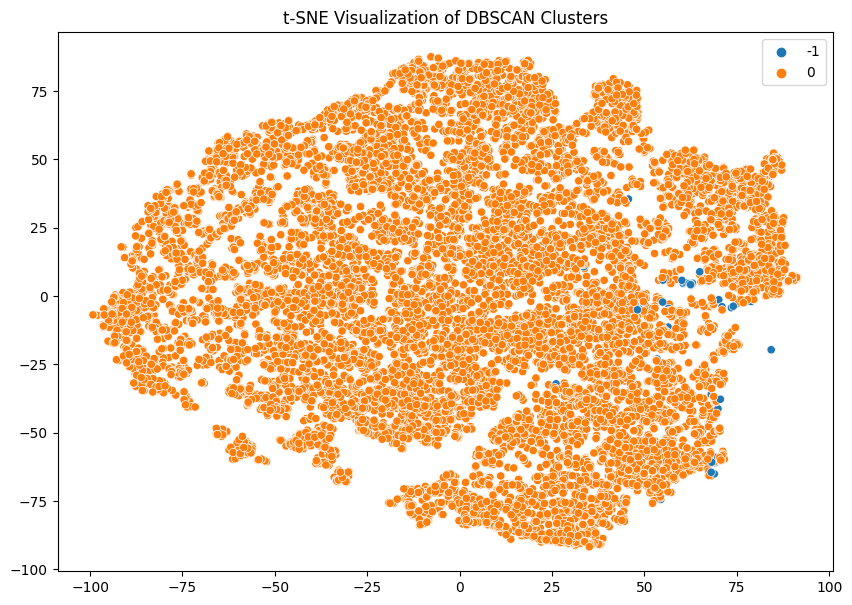

In [10]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(basket_pca)

plt.figure(figsize=(10,7))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels_list[3][1], palette='tab10')
plt.title("t-SNE Visualization of DBSCAN Clusters")
plt.show()

## 📑 Final Observations & Insights
### 💡 Insights from Association Rules
- Products like **HOME DECORATION, SEASONAL GIFTS, RIBBON REELS** frequently purchased together → **bundle offers** potential.

### 💡 Insights from Clustering
| Cluster Type        | Business Insight                               |
| ------------------- | ---------------------------------------------- |
| 📦 Frequent Buyers  | Personalized promotions & loyalty programs     |
| 🎁 Gift Shoppers    | **Holiday marketing** campaigns                |
| 🛒 Irregular Buyers | **Reactivation campaigns** via targeted offers |
| ❗ Outliers          | Possibly large wholesale purchases or errors   |


## ✅ Summary of Outcomes

| 🔎 Aspect               | 📝 Result                                                      |
| ----------------------- | -------------------------------------------------------------- |
| **Best Clustering**     | ✅ **DBSCAN (Silhouette Score ≈ 0.79)**                         |
| **Strong Associations** | 🎯 **HOME DECORATION + SEASONAL GIFTS + RIBBON REELS**         |
| **Business Actions**    | 📬 Loyalty campaigns, 🎁 Seasonal promotions, 🛡️ Fraud review |
